## License 

Copyright 2017 - 2019 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks. 

In [1]:
# imports

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator       # for GBM

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

import shap # Python Shapley value package

# display plots in-notebook
%matplotlib inline   

/home/patrickh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Start h2o

In [2]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgxb1kzrk
  JVM stdout: /tmp/tmpgxb1kzrk/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpgxb1kzrk/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,1 month and 22 days
H2O cluster name:,H2O_from_python_patrickh_y2qrti
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 1. Load, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

#### Import data and clean

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 
data = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Assign modeling roles

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID', 'AGE', 'EDUCATION', 'SEX', 'MARRIAGE', 'LIMIT_BAL']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Ensure target is handled as a categorical variable

In [5]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics

In [6]:
data[X + [y]].describe()

Rows:30000
Cols:19




,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,-0.016700000000000118,-0.1337666666666667,-0.16619999999999988,-0.2206666666666661,-0.26620000000000105,-0.2910999999999988,51223.33090000043,49179.07516666629,47013.154799999655,43262.94896666659,40311.40096666682,38871.76039999976,5663.580500000035,5921.163499999979,5225.681499999981,4826.076866666652,4799.387633333336,5215.50256666665,
maxs,8.0,8.0,8.0,8.0,8.0,8.0,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,1.1238015279973332,1.1971859730345495,1.1968675684465686,1.1691386224023357,1.1331874060027525,1.149987625607897,73635.86057552966,71173.76878252832,69349.38742703677,64332.856133916444,60797.15577026471,59554.1075367459,16563.28035402577,23040.87040205719,17606.96146980311,15666.159744032062,15278.305679144742,17777.46577543531,
zeros,14737,15730,15764,16455,16947,16286,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O Montonic GBM classifier

#### Split data into training and test sets for early stopping

In [7]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Establish monotonicity constraints based on Pearson correlation

In [8]:
pd.DataFrame(test.as_data_frame()[X + [y]].corr()[y]).iloc[:-1]

,DEFAULT_NEXT_MONTH
PAY_0,0.318419
PAY_2,0.250650
PAY_3,0.220672
PAY_4,0.201708
PAY_5,0.193368
PAY_6,0.183716
BILL_AMT1,-0.023252
BILL_AMT2,-0.019563
BILL_AMT3,-0.021105
BILL_AMT4,-0.018092


In [9]:
# positive Pearson correlation w/ P_DEFAULT_NEXT_MONTH == positive constraint == 1
# negative Pearson correlation w/ P_DEFAULT_NEXT_MONTH == negative constraint == -1
names = list(test.as_data_frame()[X + [y]].corr()[y].index)[:-1]
signs = list([int(i) for i in np.sign(test.as_data_frame()[X + [y]].corr()[y].values[:-1])])

mc = {}
for i, name in enumerate(names):
    mc[name] = signs[i]

mc

{'BILL_AMT1': -1,
 'BILL_AMT2': -1,
 'BILL_AMT3': -1,
 'BILL_AMT4': -1,
 'BILL_AMT5': -1,
 'BILL_AMT6': -1,
 'PAY_0': 1,
 'PAY_2': 1,
 'PAY_3': 1,
 'PAY_4': 1,
 'PAY_5': 1,
 'PAY_6': 1,
 'PAY_AMT1': -1,
 'PAY_AMT2': -1,
 'PAY_AMT3': -1,
 'PAY_AMT4': -1,
 'PAY_AMT5': -1,
 'PAY_AMT6': -1}

#### Train h2o monotonic GBM classifier 

In [10]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,                # maximum 150 trees in GBM
                                     max_depth=4,               # trees can have maximum depth of 4
                                     sample_rate=0.9,           # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,       # use 90% of variables in each iteration (tree)
                                     #balance_classes=True,     # sample to balance 0/1 distribution of target - can help LOCO
                                     stopping_rounds=5,         # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1,     # for reproducibility, set higher for bigger data
                                     monotone_constraints=mc,   # enforces monotonicity wrt each input
                                     model_id='dia_gbm',        # for locating the model in Flow UI 
                                     seed=12345)                # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.77


#### Display Shapley variable importance

/home/patrickh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


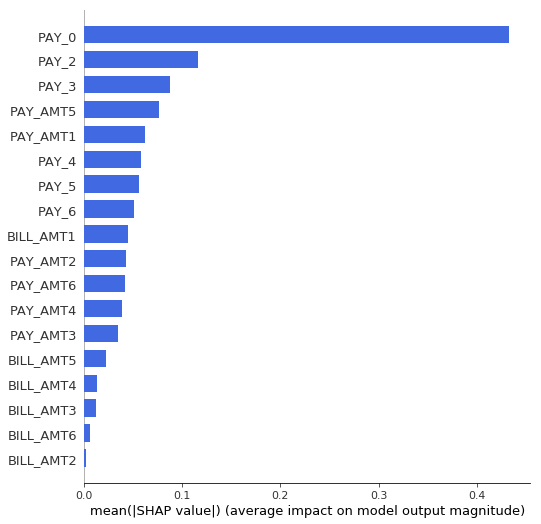

In [11]:
contributions = model.predict_contributions(test)
contributions_matrix = contributions.as_data_frame().as_matrix()
shap_values = contributions_matrix[:,:-1]
shap.summary_plot(shap_values, X, plot_type='bar', color='royalblue')

#### Bind model predictions to test data for further calculations

In [12]:
# cbind predictions to training frame
# give them a nice name
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat]
test_yhat = test.cbind(preds1[yhat]).as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


# 3. Select a Probability Cutoff by Maximizing F1 Statistic

#### Function to calculate AUC-PR Curve

In [13]:
def get_prroc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame
        
prroc_frame = get_prroc(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH')

#### Select best cutoff

In [14]:
best_cut = prroc_frame.loc[prroc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
print('%.2f' % best_cut)

0.26


#### Plot AUC-PR Curve

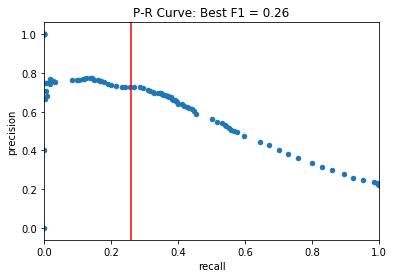

In [15]:
# Plot P-R ROC w/ best cutoff
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = prroc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

# 4. Report Raw Confusion Matrices

#### Function to print confusion matrices by an input variable

In [16]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[i, j] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame
    
    
get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1083,920
predicted: 0,949,5988


#### Report confusion matrices by `MARRIAGE` level 

In [17]:
marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
test_yhat['MARRIAGE'] = test_yhat['MARRIAGE'].apply(lambda i: marriage_dict[i]) 

In [18]:
levels = list(test_yhat['MARRIAGE'].unique())
levels

['married', 'single', 'divorced', 'other']

#### Confusion matrix for `Marriage = married`

In [19]:
married_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='MARRIAGE', level='married', cutoff=best_cut)
married_cm

Confusion matrix by MARRIAGE=married


,actual: 1,actual: 0
predicted: 1,527,450
predicted: 0,453,2660


#### Confusion matrix for `Marriage = single`

In [20]:
single_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='MARRIAGE', level='single', cutoff=best_cut)
single_cm

Confusion matrix by MARRIAGE=single


,actual: 1,actual: 0
predicted: 1,545,457
predicted: 0,481,3256


#### Confusion matrix for `Marriage = divorced`

In [21]:
divorced_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='MARRIAGE', level='divorced', cutoff=best_cut)
divorced_cm

Confusion matrix by MARRIAGE=divorced


,actual: 1,actual: 0
predicted: 1,10,13
predicted: 0,13,59


#### Confusion matrix for `MARRIAGE = other`

In [22]:
other_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='MARRIAGE', level='other', cutoff=best_cut)
other_cm

Confusion matrix by MARRIAGE=other


,actual: 1,actual: 0
predicted: 1,1,0
predicted: 0,2,13


# 5. Disparate Impact Analysis (DIA)

To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the GBM's overall performance and how it behaves when predicting:

* Default correctly
* Non-default correctly
* Default incorrectly (type I errors)
* Non-default incorrectly (type II errors)

In a real-life lending scenario, type I errors essentially amount to false accusations of financial impropriety and type II errors result in awarding loans to undeserving customers. Both types of errors can be costly to the lender too. Type I errors likely result in lost interest and fees. Type II errors often result in write-offs.

#### Dictionary of metrics used to assess group parity

In [23]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
#'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Accuracy':   '(tp + tn) / (tp + tn +fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

#### Utility function to translate metrics into Pandas statements

In [24]:
# small utility function
# translates abbreviated metric expressions into executable Python statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression


#### Calculate and report group metrics

In [25]:
# initialize dict of confusion matrices and corresponding rows of dataframe
cm_dict = {'other': other_cm, 
           'married': married_cm, 
           'single': single_cm, 
           'divorced': divorced_cm} 

metrics_frame = pd.DataFrame(index=levels) # frame for metrics

# nested loop through:
# - marriage statuses
# - metrics 
for level in levels:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])

        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results                
metrics_frame

,Adverse Impact,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
married,0.238875,0.779218,0.537755,0.539406,0.855305,0.854481,0.144695,0.460594,0.462245,0.145519
single,0.211437,0.802068,0.531189,0.543912,0.876919,0.871287,0.123081,0.456088,0.468811,0.128713
divorced,0.242105,0.726316,0.434783,0.434783,0.819444,0.819444,0.180556,0.565217,0.565217,0.180556
other,0.062500,0.875000,0.333333,1.000000,1.000000,0.866667,0.000000,0.000000,0.666667,0.133333


#### Calculate and report disparity

In [26]:
ref_level = 'married' # user-defined reference level

parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value

# init frame to store disparity measures
disp_frame = pd.DataFrame(index=levels)

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[ref_level, :]

# change column names
disp_frame.columns=[col + ' Disparity' for col in metrics_frame.columns]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Adverse Impact Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
married,1,1,1,1,1,1,1,1,1,1
single,0.885135,1.02932,0.98779,1.00835,1.02527,1.01967,0.850627,0.990217,1.0142,0.88451
divorced,1.01352,0.932109,0.808514,0.806039,0.958072,0.958996,1.24784,1.22715,1.22277,1.24077
other,0.261643,1.12292,0.619861,1.85389,1.16917,1.01426,0,0,1.44224,0.916262


#### Assess and report group parity
A binary indication of parity for metrics is reported by simply checking whether disparity values are within the user-defined thresholds. Further parity indicators are defined as combinations of other disparity values:

* Type I Parity: Fairness in both FDR Parity and FPR Parity
* Type II Parity: Fairness in both FOR Parity and FNR Parity
* Equalized Odds: Fairness in both FPR Parity and TPR Parity
* Supervised Fairness: Fairness in both Type I and Type II Parity
* Overall Fairness: Fairness across all parities for all metrics

In [27]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=levels, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - marriage statuses
# - disparity metrics
for i, _ in enumerate(levels):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (parity_threshold_low < disp_frame.iat[i, j] < parity_threshold_hi)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all metrics
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
par_frame.loc['all', :] = par_frame.all(axis='index')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)

,Adverse Impact Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
married,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
single,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
divorced,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
other,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False
all,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False
